In [245]:
import os

# Biopython
import Bio
from Bio import SeqIO
from Bio import Entrez

import subprocess

# some Python standard lib
import gzip
import random
import glob

# python modules for data analysis
import numpy as np
import scipy
import pandas as pd

# plotting of data
import matplotlib.pyplot as plt
import seaborn as sns

from Bio.Blast.Applications import NcbiblastnCommandline
from Bio.Blast import NCBIWWW, NCBIXML

In [246]:
input_file = "barcodes/barcode03"
unique_fastq = "b03/merged_output.fastq"
fasta_input = "b03/fastab03"

In [247]:
def calculate_gc_content(sequence):
    gc_count = sum(1 for base in sequence if base in "GC")
    return (gc_count / len(sequence)) * 100 if len(sequence) > 0 else 0


def fastq_to_fasta(input_fastq, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    base_name = os.path.basename(input_fastq)[:-9]   
    output_fasta = os.path.join(output_dir, base_name + ".fasta")
    with gzip.open(input_fastq, "rt") as fastq, open(output_fasta, "w") as fasta:
        SeqIO.convert(fastq, "fastq", fasta, "fasta")
    return output_fasta


In [248]:
all_reads_data = []
sequences = []
for filename in os.listdir(input_file):
    if filename.endswith(".fastq.gz"):
        file_path = os.path.join(input_file, filename)
        fastq_to_fasta(file_path, fasta_input)
        handle = gzip.open(file_path, "rt") 

        with handle:
            for record in SeqIO.parse(handle, "fastq"):
                read_id = record.id
                sequence = str(record.seq)
                sequences.append(sequence)
                quality_scores = record.letter_annotations["phred_quality"]

                read_length = len(sequence)
                average_quality = sum(quality_scores) / len(quality_scores) if quality_scores else 0
                gc_content = calculate_gc_content(sequence)

                all_reads_data.append({
                    "File": filename,
                    "Read ID": read_id,
                    "Length": read_length,
                    "Average Quality": average_quality,
                    "GC Content (%)": gc_content
                })


In [249]:
fasta_files = glob.glob("b03/fastab03/*.fasta")  

output_file = "b03/combined_sequences03.fasta"

with open(output_file, "w") as outfile:
    for file in fasta_files:
        with open(file, "r") as infile:
            for record in SeqIO.parse(infile, "fasta"):
                SeqIO.write(record, outfile, "fasta")

print(f"✅ Combined {len(fasta_files)} FASTA files into {output_file}")

✅ Combined 432 FASTA files into b03/combined_sequences03.fasta


In [250]:
df = pd.DataFrame(all_reads_data)
df

File  \
0       FBA04822_pass_barcode03_a95aace0_baba7488_233....   
1       FBA04822_pass_barcode03_a95aace0_baba7488_233....   
2       FBA04822_pass_barcode03_a95aace0_baba7488_233....   
3       FBA04822_pass_barcode03_a95aace0_baba7488_233....   
4       FBA04822_pass_barcode03_a95aace0_baba7488_233....   
...                                                   ...   
231514  FBA04822_pass_barcode03_a95aace0_baba7488_425....   
231515  FBA04822_pass_barcode03_a95aace0_baba7488_425....   
231516  FBA04822_pass_barcode03_a95aace0_baba7488_425....   
231517  FBA04822_pass_barcode03_a95aace0_baba7488_425....   
231518  FBA04822_pass_barcode03_a95aace0_baba7488_425....   

                                     Read ID  Length  Average Quality  \
0       1b5d16ad-909d-4ff1-a875-c07a965b92e1    8197        15.812492   
1       c5a0d07b-52b2-499b-81dc-1885f54dd80e    1425        13.637193   
2       5dc38cab-b814-4162-8327-7e0f905e4076     274        16.306569   
3       a90623eb-9cdb-4239-917e-a2b24eb9a3be    2456        16.287866   
4       4077326e-0717-44ef-aba7-7c4bdf014b06    4064        17.125738   
...                                      ...     ...              ...   
231514  238e8e8d-0d2c-4239-9827-679a5a3813b4     449        16.407572   
231515  25c5386d-6aef-4b4d-b0bb-fa954b6fbac9     843        12.880190   
231516  a4b6173c-0ad2-499b-b9fa-0d2a4720a6bc     733        12.098226   
231517  73f2b664-21f4-47b9-9b16-ed7b2fe52362     458        12.266376   
231518  d57f3f24-004f-4756-a9cb-1bace3ecb4cb    1137        12.093228   

        GC Content (%)  
0            57.301452  
1            42.035088  
2            28.102190  
3            56.514658  
4            56.397638  
...                ...  
231514       42.316258  
231515       45.314353  
231516       35.334243  
231517       27.729258  
231518       63.676341  

[231519 rows x 5 columns]

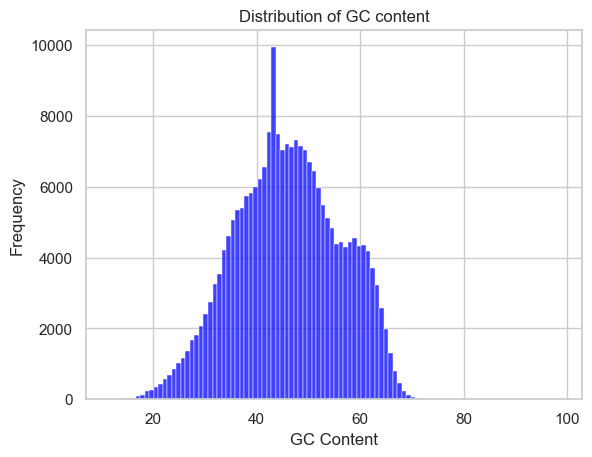

In [251]:
sns.histplot(df['GC Content (%)'], kde=False, bins=100, color='blue')  
plt.title("Distribution of GC content")
plt.xlabel("GC Content")
plt.ylabel("Frequency")
plt.show()

In [252]:
# sequences exists, retriving file names
names = df['Read ID']
print(names[0])

1b5d16ad-909d-4ff1-a875-c07a965b92e1


In [253]:
def run_cmsearch(fasta_dir, cm_model, output_dir, cpu = 8, threshold = 500):
    os.makedirs(output_dir, exist_ok=True)
    for filename in os.listdir(fasta_dir):
        if filename.endswith(".fasta"):
            fasta_path = os.path.join(fasta_dir, filename)
            output_path = os.path.join(output_dir, f"hits_{filename}.csv")
            
            command = (
                f"cmsearch --cpu {cpu} --noali --notrunc -g -T {threshold} "
                f"--tblout {output_path} {cm_model} {fasta_path}"
            )
            print(f"Running cmsearch on {filename}...")
            os.system(command)

In [254]:
fasta_dir = "b03/fastab03"        
cm_model = "data/RF00177.cm"     
output_dir = "b03/hits"               

# Run cmsearch on all .fasta files
run_cmsearch(fasta_dir, cm_model, output_dir)

Running cmsearch on FBA04822_pass_barcode03_a95aace0_baba7488_87.fasta...
# cmsearch :: search CM(s) against a sequence database
# INFERNAL 1.1.5 (Sep 2023)
# Copyright (C) 2023 Howard Hughes Medical Institute.
# Freely distributed under the BSD open source license.
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# query CM file:                         data/RF00177.cm
# target sequence database:              b03/fastab03/FBA04822_pass_barcode03_a95aace0_baba7488_87.fasta
# CM configuration:                      glocal
# tabular output of hits:                b03/hits/hits_FBA04822_pass_barcode03_a95aace0_baba7488_87.fasta.csv
# show alignments in output:             no
# sequence reporting threshold:          score >= 500
# truncated sequence detection:          off
# number of worker threads:              8 [--cpu]
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

Query:       SSU_rRNA_bacteria  [CLEN=1533]
Accession:   RF00177
Descr

In [255]:
folder_path = "b03/hits"
all_dataframes = []
for file_name in os.listdir(folder_path):
    # Check if the file is a CSV file
    if file_name.endswith('.csv'):
        file_path = os.path.join(folder_path, file_name)
        
        try:
            df = pd.read_csv(file_path, sep="\s+", header=None, comment="#")
            
            if not df.empty and df.shape[1] > 0:
                all_dataframes.append(df)
            else:
                print(f"Skipping empty or malformed file: {file_name}")
        
        except pd.errors.EmptyDataError:
            # Handle empty CSV files
            print(f"Skipping empty file: {file_name}")
        
        except pd.errors.ParserError:
            # Handle parsing errors (e.g., if the file is not a valid CSV)
            print(f"Skipping malformed file: {file_name}")
        
        except Exception as e:
            # General exception handler for any other errors
            print(f"Error reading {file_name}: {e}")

Skipping empty file: hits_FBA04822_pass_barcode03_a95aace0_baba7488_269.fasta.csv
Skipping empty file: hits_FBA04822_pass_barcode03_a95aace0_baba7488_163.fasta.csv
Skipping empty file: hits_FBA04822_pass_barcode03_a95aace0_baba7488_355.fasta.csv
Skipping empty file: hits_FBA04822_pass_barcode03_a95aace0_baba7488_388.fasta.csv
Skipping empty file: hits_FBA04822_pass_barcode03_a95aace0_baba7488_341.fasta.csv
Skipping empty file: hits_FBA04822_pass_barcode03_a95aace0_baba7488_207.fasta.csv
Skipping empty file: hits_FBA04822_pass_barcode03_a95aace0_baba7488_68.fasta.csv
Skipping empty file: hits_FBA04822_pass_barcode03_a95aace0_baba7488_427.fasta.csv
Skipping empty file: hits_FBA04822_pass_barcode03_a95aace0_baba7488_156.fasta.csv
Skipping empty file: hits_FBA04822_pass_barcode03_a95aace0_baba7488_360.fasta.csv
Skipping empty file: hits_FBA04822_pass_barcode03_a95aace0_baba7488_295.fasta.csv
Skipping empty file: hits_FBA04822_pass_barcode03_a95aace0_baba7488_406.fasta.csv
Skipping empty fi

<>:9: SyntaxWarning: invalid escape sequence '\s'
<>:9: SyntaxWarning: invalid escape sequence '\s'
/var/folders/jg/0ky1rst55w59tncf1d8dt3900000gn/T/ipykernel_1489/4017396501.py:9: SyntaxWarning: invalid escape sequence '\s'
  df = pd.read_csv(file_path, sep="\s+", header=None, comment="#")


In [271]:
if all_dataframes:
    combined_df = pd.concat(all_dataframes)
combined_df
combined_df.to_csv("b03/temp1.csv", index=False)

In [273]:
df = pd.read_csv("b03/temp1.csv")
df = df.drop(columns=["1", "4", "5", "10", "11", "16", "17", "19", "20", "21", "22", "23", "24", "25", "26"]) 
df.columns = ["seq_id", "cm_type", "-", "+", "Seq from", "Seq to", "Strand", "GC", "Bias", "Score", "E-value", "Description of target"] 
df


seq_id            cm_type        -     +  \
0    8688914b-7363-469a-b789-ce63a86d04ff  SSU_rRNA_bacteria  RF00177  1533   
1    3c02af09-d02b-4249-8d55-e4601f18554d  SSU_rRNA_bacteria  RF00177  1533   
2    52b53370-895d-4c53-bcdd-5bd2a4ff121c  SSU_rRNA_bacteria  RF00177  1533   
3    bdc0e0fa-1329-4705-9194-a5e9f5fb6c5f  SSU_rRNA_bacteria  RF00177  1533   
4    c79de374-06a6-4980-85ca-31f67ec28d19  SSU_rRNA_bacteria  RF00177  1533   
..                                    ...                ...      ...   ...   
218  8b73d8a2-887f-4d2c-87d0-dfbf647ebb0e  SSU_rRNA_bacteria  RF00177  1533   
219  07fac5e2-0967-4e1b-855c-85b755ce7ef6  SSU_rRNA_bacteria  RF00177  1533   
220  fe813122-e253-4346-86ed-71872b20d861  SSU_rRNA_bacteria  RF00177  1533   
221  f835e7d4-d9d2-4968-a80d-9c79ea9ebce1  SSU_rRNA_bacteria  RF00177  1533   
222  f497683d-6429-4cc6-905f-ed0e58c3cf0a  SSU_rRNA_bacteria  RF00177  1533   

     Seq from  Seq to Strand    GC  Bias   Score       E-value  \
0        2081    3548      +  0.55  13.3   796.4  2.200000e-26   
1        1951    3459      +  0.51   3.7   957.7  2.200000e-31   
2        2652    1148      -  0.52  12.3  1154.8  6.500000e-36   
3        3583    2048      -  0.49   1.9  1122.4  5.300000e-35   
4        6414    7904      +  0.52   5.2  1100.2  2.200000e-34   
..        ...     ...    ...   ...   ...     ...           ...   
218      2247     768      -  0.58  29.5   834.2  1.400000e-27   
219      2147    3673      +  0.53  14.0  1043.4  5.000000e-33   
220      2948    4398      +  0.48   0.5   613.5  7.600000e-21   
221      3855    2325      -  0.52   3.9  1285.9  5.000000e-40   
222      3658    2330      -  0.55  13.1   914.2  9.100000e-30   

    Description of target  
0                  ch=287  
1                  ch=330  
2                  ch=225  
3                  ch=298  
4                  ch=246  
..                    ...  
218                 ch=64  
219                ch=281  
220                ch=491  
221                 ch=30  
222                ch=410  

[223 rows x 12 columns]

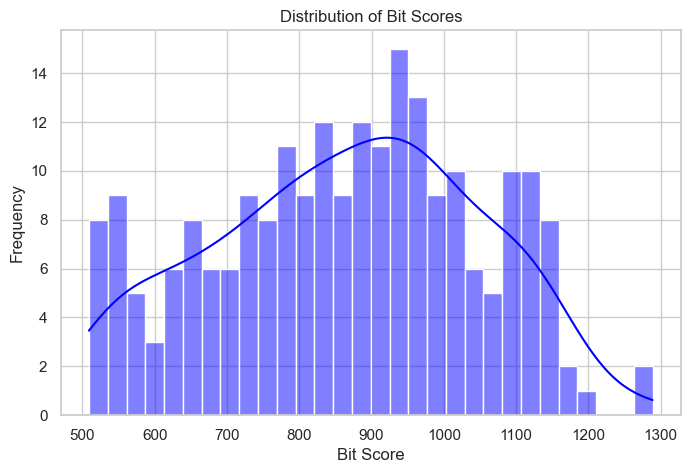

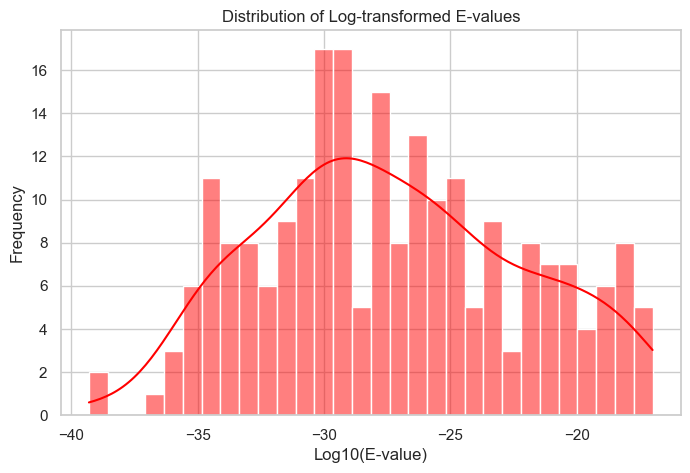

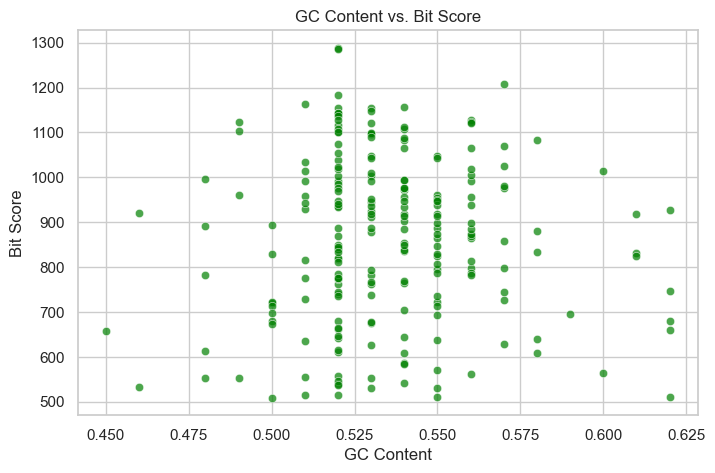

In [274]:
df["log_E_value"] = np.log10(df["E-value"].replace(0, np.nan))

# Set Seaborn style
sns.set(style="whitegrid")

# Plot 1: Histogram of Bit Scores
plt.figure(figsize=(8, 5))
sns.histplot(df["Score"], bins=30, kde=True, color="blue")
plt.xlabel("Bit Score")
plt.ylabel("Frequency")
plt.title("Distribution of Bit Scores")
plt.show()

# Plot 2: Histogram of Log E-values
plt.figure(figsize=(8, 5))
sns.histplot(df["log_E_value"].dropna(), bins=30, kde=True, color="red")
plt.xlabel("Log10(E-value)")
plt.ylabel("Frequency")
plt.title("Distribution of Log-transformed E-values")
plt.show()

# Plot 3: GC Content vs. Bit Score (Scatter)
plt.figure(figsize=(8, 5))
sns.scatterplot(x=df["GC"], y=df["Score"], alpha=0.7, color="green")
plt.xlabel("GC Content")
plt.ylabel("Bit Score")
plt.title("GC Content vs. Bit Score")
plt.show()

In [275]:
ids = list(df['seq_id'])
print(ids[0])

8688914b-7363-469a-b789-ce63a86d04ff


In [276]:
reads = []
names = list(names)
for nom in ids : 
    i = names.index(nom)
    reads.append(sequences[i])

In [277]:
a =[]
b=[]
sens=[]
for i in range(len(df['seq_id'])):
    a.append(df['Seq from'][i])
    b.append(df['Seq to'][i])
    sens.append(df['Strand'][i])


In [278]:
seq_to_blast = []
for i in range(len(df['seq_id'])):
    if sens[i] == '+':
        seq_to_blast.append(reads[i][a[i]: b[i]])
    else: 
        seq_to_blast.append(reads[i][b[i]: a[i]])

In [279]:
total_bases = 0
for seq in  seq_to_blast:
    total_bases += len(seq)
if total_bases % 999999 > 0:
    num_of_files = total_bases // 999999 + 1
else:
    num_of_files = total_bases // 999999
print(num_of_files)

1


In [280]:
list_of_file_names = []
for i in range(num_of_files):
    list_of_file_names.append(f"b03/hits_seq_{i}.fasta")
print(list_of_file_names)

['b03/hits_seq_0.fasta']


In [281]:
def split_fasta_files(list_of_file_names, seq_to_blast, max_bases=999999):
    nob = 0  
    file_index = 0  

    fasta_file = open(list_of_file_names[file_index], "w")  

    for i, seq in enumerate(seq_to_blast):
        seq_length = len(seq)
        if nob + seq_length > max_bases:
            fasta_file.close()  
            file_index += 1  
            if file_index >= len(list_of_file_names):  
                print("Warning: Not enough filenames provided!")
                break
            fasta_file = open(list_of_file_names[file_index], "w")  
            nob = 0
        fasta_file.write(f">seq_{i}\n{seq}\n")
        nob += seq_length  
    fasta_file.close() 

In [282]:
split_fasta_files(list_of_file_names, seq_to_blast)

In [283]:
blast_db = "nt_prok/nt_prok" 

input_file = "b03/hits_seq_0.fasta"
output_file = "b03/blast_results.csv"
blastn_path = "/opt/homebrew/bin/blastn"


blast_command = f"{blastn_path} -query {input_file} -db {blast_db} -out {output_file} -outfmt '10 qseqid sseqid pident length evalue ssciname' -num_threads 8 -max_target_seqs 20"

os.system(blast_command)



print(f"BLAST results saved to {output_file}")

BLAST results saved to b03/blast_results.csv


In [284]:
df = pd.read_csv("b03/blast_results.csv", header=None)
df.columns = ["query_id", "subject_id", "percent_identity", "alignment_length", "evalue", "scientific_name"]
df

query_id                     subject_id  percent_identity  \
0       seq_0    gi|324960142|gb|HQ716499.1|            89.526   
1       seq_0    gi|324960196|gb|HQ716554.1|            89.455   
2       seq_0    gi|192989713|gb|EU779453.1|            88.577   
3       seq_0    gi|169285729|gb|EU470254.1|            87.930   
4       seq_0   gi|474429669|dbj|AB616461.1|            86.689   
...       ...                            ...               ...   
5318  seq_222  gi|1013285497|dbj|LC028684.1|            88.077   
5319  seq_222    gi|169281042|gb|EU465567.1|            90.342   
5320  seq_222    gi|399935680|gb|JX095885.1|            89.242   
5321  seq_222    gi|399935006|gb|JX095211.1|            89.242   
5322  seq_222    gi|399935154|gb|JX095359.1|            89.134   

      alignment_length  evalue  scientific_name  
0                 1413     0.0              NaN  
1                 1413     0.0              NaN  
2                 1427     0.0              NaN  
3                 1425     0.0              NaN  
4                 1465     0.0              NaN  
...                ...     ...              ...  
5318              1300     0.0              NaN  
5319              1170     0.0              NaN  
5320              1227     0.0              NaN  
5321              1227     0.0              NaN  
5322              1224     0.0              NaN  

[5323 rows x 6 columns]

In [285]:
df["percent_identity"] = pd.to_numeric(df["percent_identity"])
df = df.sort_values(by="percent_identity", ascending=False)
df

query_id                    subject_id  percent_identity  \
1621   seq_65  gi|548958754|dbj|AB746674.1|            98.148   
1617   seq_65  gi|283130976|dbj|AB494794.1|            98.148   
1633   seq_65   gi|315227985|gb|HQ616112.1|            98.113   
209    seq_10   gi|698039409|gb|KM650574.1|            97.778   
211    seq_10   gi|698039327|gb|KM650492.1|            97.778   
...       ...                           ...               ...   
1097   seq_48  gi|2557660421|gb|OR395915.1|            76.880   
5005  seq_212   gi|283981808|gb|GU303976.1|            76.863   
5007  seq_212   gi|126653580|gb|EF436359.1|            76.732   
1099   seq_48  gi|2557660621|gb|OR396115.1|            76.602   
5009  seq_212   gi|50788744|dbj|AB185513.1|            76.379   

      alignment_length         evalue  scientific_name  
1621                54   3.180000e-14              NaN  
1617                54   3.180000e-14              NaN  
1633                53   1.140000e-13              NaN  
209                 45   8.880000e-10              NaN  
211                 45   8.880000e-10              NaN  
...                ...            ...              ...  
1097              1436   0.000000e+00              NaN  
5005              1288  3.240000e-178              NaN  
5007              1285  7.020000e-175              NaN  
1099              1436   0.000000e+00              NaN  
5009              1342  1.170000e-172              NaN  

[5323 rows x 6 columns]

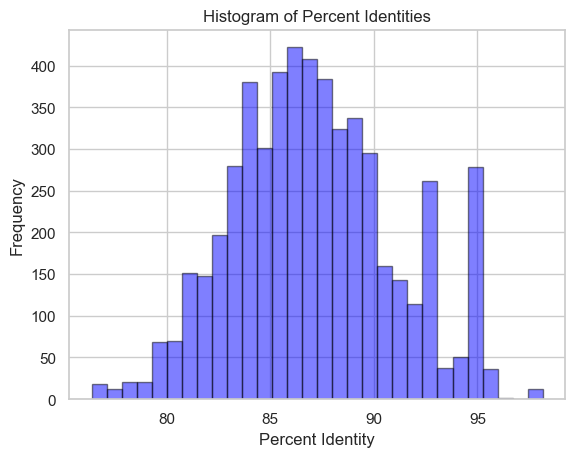

In [286]:
plt.hist(df["percent_identity"], bins=30, color="blue", edgecolor="black", alpha=0.5)


plt.xlabel("Percent Identity")
plt.ylabel("Frequency")
plt.title("Histogram of Percent Identities")


plt.show()

In [287]:
df["percent_identity"] = pd.to_numeric(df["percent_identity"], errors="coerce")
df["alignment_length"] = pd.to_numeric(df["alignment_length"], errors="coerce")


df = df[(df["percent_identity"] >= 93) & (df["alignment_length"] >= 1500)]
df

query_id                     subject_id  percent_identity  \
5175  seq_221  gi|1539757975|emb|LR134292.1|            94.997   
5173  seq_221  gi|1539757975|emb|LR134292.1|            94.997   
5174  seq_221  gi|1539757975|emb|LR134292.1|            94.997   
5172  seq_221  gi|1539757975|emb|LR134292.1|            94.997   
5176  seq_221  gi|1539757975|emb|LR134292.1|            94.997   
...       ...                            ...               ...   
5281  seq_221    gi|527122546|gb|CP003025.1|            94.615   
5241  seq_221   gi|1784306618|gb|CP046624.1|            94.359   
1130   seq_50   gi|2853641462|gb|CP173573.1|            93.047   
1247   seq_50   gi|2651015587|gb|CP142563.1|            93.043   
1137   seq_50   gi|2101313445|gb|CP083701.1|            93.043   

      alignment_length  evalue  scientific_name  
5175              1559     0.0              NaN  
5173              1559     0.0              NaN  
5174              1559     0.0              NaN  
5172              1559     0.0              NaN  
5176              1559     0.0              NaN  
...                ...     ...              ...  
5281              1560     0.0              NaN  
5241              1560     0.0              NaN  
1130              1539     0.0              NaN  
1247              1538     0.0              NaN  
1137              1538     0.0              NaN  

[134 rows x 6 columns]

In [288]:
def extract_accession(subject_id):
    parts = subject_id.split("|")
    for part in parts:
        if part.replace(".", "").isdigit():  # Checks if it's an accession number
            return part
    return subject_id  # Return original if no valid accession found

In [289]:

Entrez.email = "barovic17@example.com"  # Replace with your email

def get_organism_name(subject_id):
    try:
        accession = extract_accession(subject_id)  
        handle = Entrez.esummary(db="nuccore", id=accession, retmode="xml")
        record = Entrez.read(handle)

        if "Title" in record[0]:
            organism = record[0]["Title"].split(",")[0]
            return organism
        else:
            return "Unknown"
        
    except Exception as e:
        print(f"Error fetching {subject_id}: {e}")
        return "Unknown"

# Apply function with sleep to prevent overloading API
df["organism_name"] = df["subject_id"].apply(lambda x: get_organism_name(x) if pd.notnull(x) else "Unknown")


/var/folders/jg/0ky1rst55w59tncf1d8dt3900000gn/T/ipykernel_1489/3826532564.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["organism_name"] = df["subject_id"].apply(lambda x: get_organism_name(x) if pd.notnull(x) else "Unknown")


In [290]:
df

query_id                     subject_id  percent_identity  \
5175  seq_221  gi|1539757975|emb|LR134292.1|            94.997   
5173  seq_221  gi|1539757975|emb|LR134292.1|            94.997   
5174  seq_221  gi|1539757975|emb|LR134292.1|            94.997   
5172  seq_221  gi|1539757975|emb|LR134292.1|            94.997   
5176  seq_221  gi|1539757975|emb|LR134292.1|            94.997   
...       ...                            ...               ...   
5281  seq_221    gi|527122546|gb|CP003025.1|            94.615   
5241  seq_221   gi|1784306618|gb|CP046624.1|            94.359   
1130   seq_50   gi|2853641462|gb|CP173573.1|            93.047   
1247   seq_50   gi|2651015587|gb|CP142563.1|            93.043   
1137   seq_50   gi|2101313445|gb|CP083701.1|            93.043   

      alignment_length  evalue  scientific_name  \
5175              1559     0.0              NaN   
5173              1559     0.0              NaN   
5174              1559     0.0              NaN   
5172              1559     0.0              NaN   
5176              1559     0.0              NaN   
...                ...     ...              ...   
5281              1560     0.0              NaN   
5241              1560     0.0              NaN   
1130              1539     0.0              NaN   
1247              1538     0.0              NaN   
1137              1538     0.0              NaN   

                                          organism_name  
5175  Streptococcus equinus strain NCTC10389 genome ...  
5173  Streptococcus equinus strain NCTC10389 genome ...  
5174  Streptococcus equinus strain NCTC10389 genome ...  
5172  Streptococcus equinus strain NCTC10389 genome ...  
5176  Streptococcus equinus strain NCTC10389 genome ...  
...                                                 ...  
5281                      Streptococcus lutetiensis 033  
5241  Streptococcus ruminicola strain CNU_G3 chromosome  
1130           Escherichia coli strain 98197 chromosome  
1247      Escherichia coli strain ExPEC_A333 chromosome  
1137  Escherichia coli strain SUISSEKPC3NDM5 chromosome  

[134 rows x 7 columns]

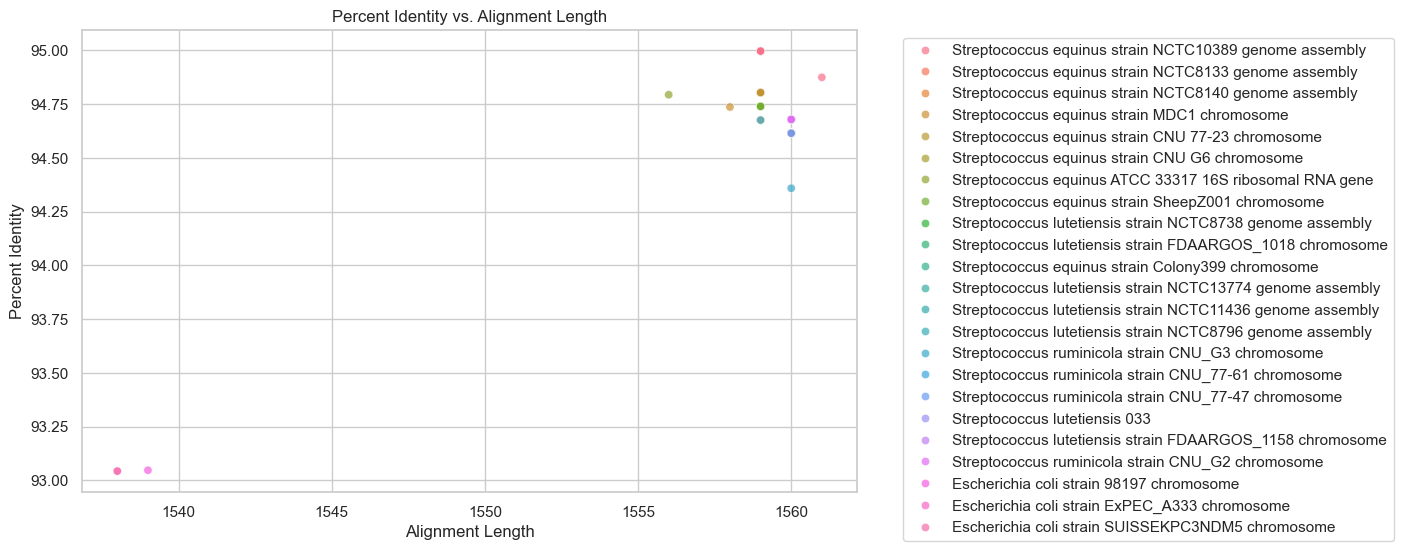

In [291]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data= df, x="alignment_length", y="percent_identity", hue = "organism_name",  alpha=0.7)
plt.xlabel("Alignment Length")
plt.ylabel("Percent Identity")
plt.title("Percent Identity vs. Alignment Length")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()